In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro

Задание 2

1. Просмотр данных

In [48]:
df = pd.read_csv('/home/jupyter-a.solovev-15/Finally_project/Проект_1_Задание_2.csv', sep = ';')
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [50]:
# Пропущенных значений нет, типы менять не нужно
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [3]:
# посмотри некоторую информацию о данных
df.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [5]:
# все user_id - уникальные, группы не равны 
df.groupby('testgroup')['user_id'].agg(['count','nunique'])

,count,nunique
testgroup,,
a,202103,202103
b,202667,202667


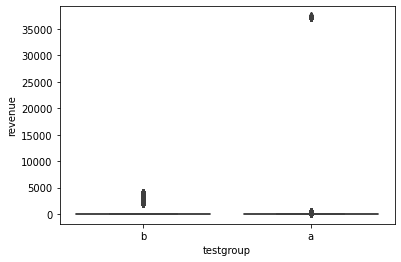

In [6]:
# визуализируем revenue с разбиением по группам
# большая часть находится в нуле, в группе А видна гетерогенность данных, в группе Б все более одородно
sns.boxplot(x=df["testgroup"], y=df["revenue"])

In [59]:
# отделим только платящих пользователей
dff = df.query('revenue > 0')

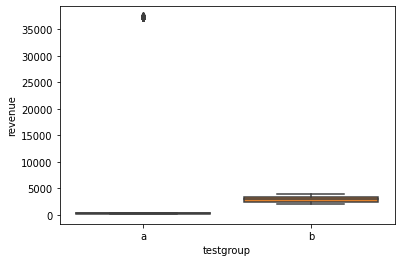

In [58]:
# визуализируем revenue лидов с разбиением по группам
# в группе А более низкие значения, но есть группа с очень высокими значениями, в группе Б все более одородно
sns.boxplot(x=dff["testgroup"], y=dff["revenue"])

2. Результаты АБ-теста

In [7]:
# Считаем значения для контрольной группы
users_a_count = df.query('testgroup == "a" ').revenue.count()
customers_a_count = df.query('testgroup == "a" & revenue > 0').revenue.count()
revenue_a = df.query('testgroup == "a" & revenue > 0').revenue.sum()
ARPU_a = revenue_a/users_a_count
ARPPU_a = revenue_a/customers_a_count
CR_a = customers_a_count/users_a_count*100

In [8]:
# Считаем значения для тестовой группы
users_b_count = df.query('testgroup == "b" ').revenue.count()
customers_b_count = df.query('testgroup == "b" & revenue > 0').revenue.count()
revenue_b = df.query('testgroup == "b" & revenue > 0').revenue.sum()
ARPU_b = revenue_b/users_b_count
ARPPU_b = revenue_b/customers_b_count
CR_b = customers_b_count/users_b_count*100

In [10]:
# Создаем таблицу с результатами
test_result = pd.DataFrame({'group': ['A', 'B'], 'users': [users_a_count, users_b_count], 
                            'buyers': [customers_a_count, customers_b_count], 'revenue': [revenue_a, revenue_b], 
                            'ARPU': [ARPU_a, ARPU_b], 'ARPPU': [ARPPU_a, ARPPU_b], 
                            'CR': [CR_a, CR_b]})

In [11]:
# Результаты АБ-теста
test_result

,group,users,buyers,revenue,ARPU,ARPPU,CR
0,A,202103,1928,5136189,25.413720,2663.998444,0.953969
1,B,202667,1805,5421603,26.751287,3003.658172,0.890624


3. Разница в группах, гипотезы

In [ ]:
# Считаем на сколько выросли показатели в тестовой группе, по сравнению с контрольной
diff_users = (users_b_count-users_a_count)/users_a_count *100
diff_buyers = (customers_b_count-customers_a_count)/customers_a_count *100
diff_revenue = (revenue_b-revenue_a)/revenue_a *100
diff_ARPU = (ARPU_b-ARPU_a)/ARPU_a *100
diff_ARPPU = (ARPPU_b-ARPPU_a)/ARPPU_a *100
diff_CR = (CR_b-CR_a)/CR_a *100

In [91]:
# Создаем таблицу с результатами
diff_result = pd.DataFrame([['users', diff_users], ['buyers', diff_buyers], ['revenue', diff_revenue], 
                   ['ARPU', diff_ARPU], ['ARPPU', diff_ARPPU], ['CR', diff_CR]], 
                  columns=['metrics', 'relative_different'])

In [93]:
# Результаты сравнения групп, Б над А, %
diff_result

,metrics,relative_different
0,users,0.279066
1,buyers,-6.379668
2,revenue,5.556922
3,ARPU,5.263168
4,ARPPU,12.749997
5,CR,-6.640203


Гипотезы:  
    1) ARPU в тестовой группе выше, чем в контрольной  
    2) ARPPU в тестовой группе выше, чем в контрольной  
    3) Конверсия в контрольной группе выше, чем в тестовой

4. Проверка гипотез

Для сравнение ARPU и ARPPU мы будем пользоваться бутстрапом для сравнения средних значений revenue пользователей по группам и revenue лидов по группам.  
Также, для сравнения с бутстрапом, будем проверять результаты, используя критерий Манна-Уитни, который проверяет равенство распределений, а не средних. Его мы можем использовать, так как объем выборок у нас примерно одинаковый. Его мы будем использовать, так как у нас в контрольной группе есть необычно высокие значения, природу которых мы не знаем, и которые будут влиять на среднее значение    
Т-тестом не будет пользоваться, так как дисперсия в группах не гомогенна (отсутствие нормальности компенсируется объемом выборок).  





ARPU

ARPU - это средний доход, который получаем от каждого активного пользователя 
Поэтому далее будем сравнивать доход всех пользователей по группам

Гипотезы:  
H0 – в генеральной совокупности никакого различия между средними значениями нет  
H1 – средние в генеральной совокупности не равны (альтернативная гипотеза)

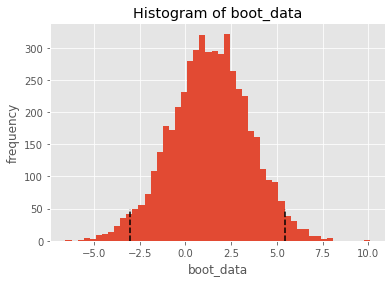

In [112]:
# Проверка гипотезы о равенстве средних с помощью бутстрапа
booted_data_mean = get_bootstrap_mean(df[df.testgroup == 'b'].revenue, df[df.testgroup == 'a'].revenue, boot_it = 5000)

In [114]:
# Интерпретация результата
p_value_1 = booted_data_mean["p_value"]
alpha = 0.05
if p_value_1 > alpha:
    H = 'Мы не можем отклонить H0'
else:
    H = 'Мы отклоняем H0'
print(f'p={round(p_value_1,2)}, следует {H}')

p=0.53, следует Мы не можем отклонить H0


In [133]:
# Сравним бутстрап с М-У
stats.mannwhitneyu(x = df[df.testgroup == 'b'].revenue, y = df[df.testgroup == 'a'].revenue)

MannwhitneyuResult(statistic=20468349325.0, pvalue=0.06269701316074398)

Гипотезы:  
H0 – в генеральной совокупности никакого различия между распределениями нет  
H1 – распределения в генеральной совокупности не равны (альтернативная гипотеза)  
pvalue > 0.05, значит принимаем H0

ARPPU

ARPU - это средний доход, который получаем от каждого платящего пользователя
Поэтому далее будем сравнивать доход всех пользователей по группам

In [120]:
# Датафрейм с платящими пользователями
dff

,user_id,revenue,testgroup
72,73,351,a
160,161,3797,b
341,342,290,a
377,378,3768,b
385,386,250,a
...,...,...,...
404315,404316,262,a
404525,404526,3120,b
404543,404544,369,a
404602,404603,251,a


Гипотезы:  
H0 – в генеральной совокупности никакого различия между средними значениями нет  
H1 – средние в генеральной совокупности не равны (альтернативная гипотеза)

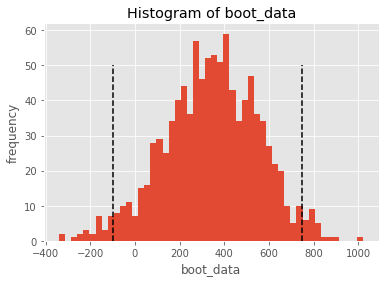

In [127]:
# Проверка гипотезы о равенстве средних с помощью бутстрапа
booted_data_mean = get_bootstrap_mean(dff[dff.testgroup == 'b'].revenue, dff[dff.testgroup == 'a'].revenue, boot_it = 1000)

In [128]:
# интерпретация результата
p_value_1 = booted_data_mean["p_value"]
alpha = 0.05
if p_value_1 > alpha:
    H = 'Мы не можем отклонить H0'
else:
    H = 'Мы отклоняем H0'
print(f'p={round(p_value_1,2)}, следует {H}')

p=0.1, следует Мы не можем отклонить H0


In [146]:
# Сравним бутстрап с М-У
statistic, p_value_2 = stats.mannwhitneyu(x = dff[dff.testgroup == 'b'].revenue, y = dff[dff.testgroup == 'a'].revenue)

Гипотезы:  
H0 – в генеральной совокупности никакого различия между распределениями нет  
H1 – распределения в генеральной совокупности не равны (альтернативная гипотеза)  


In [148]:
# интерпретация результата
alpha = 0.05
if p_value_2 > alpha:
    H = 'Мы не можем отклонить H0'
else:
    H = 'Мы отклоняем H0'
print(f'p={round(p_value_2,2)}, следует {H}')

p=0.0, следует Мы отклоняем H0


Бутстрап и М-У дали нам разные результаты. Манн-Уитни и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений. В данном случае, мы не знаем природу необычно высоких значений в группе А, поэтому не можем их выбросить, а также то, что бизнесу интересен средний доход, а не его медиана или распределение, поэтому будем использовать данные бутстрапа.

CR

Проверим является ли разница конверсии в группах статистически значимой с помощью критерия хи-квадрат

In [140]:
# создаем новую колонку: платил пользователь или нет, так как Хи-квадрат тест сравнивает качественные переменные
df['lead'] = df.revenue.apply(lambda x: 'lead' if x > 0 else 'not_lead')
df.head()

,user_id,revenue,testgroup,lead
0,1,0,b,not_lead
1,2,0,a,not_lead
2,3,0,a,not_lead
3,4,0,b,not_lead
4,5,0,b,not_lead


In [141]:
# делим пользователей на 4 группы в зависимости от группы тестирования и платил он или нет
df.groupby('testgroup')['lead'].value_counts(normalize=True).mul(100).to_frame()

lead
testgroup lead               
a         not_lead  99.046031
          lead       0.953969
b         not_lead  99.109376
          lead       0.890624

In [142]:
# создаем таблицу сопряженности
pd.crosstab(df.lead, df.testgroup)

testgroup,a,b
lead,,
lead,1928,1805
not_lead,200175,200862


In [30]:
# проводим Хи-квадрат тест
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.lead, df.testgroup))

In [31]:
stat, p

(4.374729521260405, 0.03647561892312613)

In [149]:
# интерпретация результата
alpha = 0.05
if p > alpha:
    H = 'различия статистически не значимы'
else:
    H = 'различия статистически значимы'
print(f'p={round(p,2)}, следует {H}')

p=0.04, следует различия статистически значимы


5. Выводы

В ходе анализа, мы выяснили:  
    Увеличение ARPU в тестовой группе статистически не значимо  
    Увеличение ARPPU в тестовой группе статистически не значимо  
    Уменьшение CR в тестовой группе статистически значимо  
Полученные данные противоречивы, исходя из тех данных, что мы имеем, лучше будет предложение, которое предлагалось контрольной группе, так как статистическую значимость мы можем принять только у снижении CR в тестовой группе. Также стоит учесть факт, что 89.4% дохода группы А формирует 6.4% пользователей (если исключить эти данные, то предложение для группы Б лучше). Стоит запросить данные об этих покупках, и на основании их делать выводы.


In [111]:
def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

Задание 3

Чаще всего “тематические события” в мобильных играх проводят для того, чтобы удержать внимание существующих пользователей на приложении, увеличить время и периодичность использования приложения и предотвратить отток пользователей. Поэтому основные метрики, которые могли бы оценить результаты последнего прошедшего события, связаны в первую очередь с этими показателями:

Метрики, которые необходимо наблюдать:    
1) DAU (Daily Active Users), WAU (Weekly Active Users), Stickiness   
3) ASD (Average Session Duration), Length Sessions per User  
4) Churn rate/Retention Rate  
5) ARPU, ARPPU, CR  
6) Event Users / Weekly Active Users  
Все эти метрики необходимо сравнивать с периодом до ивента.

После усложнения механики набор метрик останется таким же, только также необходимо будет построить конверсионное окно уровней, отслеживая среднее время прохождения уровня и конверсию по уровням
